In [26]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [27]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [28]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [29]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [30]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [31]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [32]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

In [33]:
def calculate_target(row):
    global fee, delta, stop_loss, treshold
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + treshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, treshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(calculate_target, axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [34]:
treshold = 300
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, treshold)
gold_gains.head(20)

            gains     Open     High      Low   Settle  target
Date                                                         
1996-01-02  342.0  38830.0  39200.0  38800.0  39190.0       1
1996-01-03  361.0  39240.0  39630.0  39220.0  39620.0       1
1996-01-04   95.0  39440.0  39580.0  39410.0  39540.0       0
1996-01-05 -123.5  39780.0  39920.0  39620.0  39650.0       0
1996-01-09  104.5  39580.0  39710.0  39480.0  39690.0       0


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,361.0,39240.0,39630.0,39220.0,39620.0,1.0
1996-01-03,95.0,39440.0,39580.0,39410.0,39540.0,0.0
1996-01-04,-123.5,39780.0,39920.0,39620.0,39650.0,0.0
1996-01-05,104.5,39580.0,39710.0,39480.0,39690.0,0.0
1996-01-09,228.0,39780.0,40300.0,39780.0,40020.0,0.0
1996-01-10,-66.5,40000.0,40060.0,39880.0,39930.0,0.0
1996-01-11,-361.0,40050.0,40090.0,39650.0,39670.0,-1.0
1996-01-12,133.0,39470.0,39630.0,39400.0,39610.0,0.0
1996-01-15,142.5,39730.0,39890.0,39720.0,39880.0,0.0


In [35]:
get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,388.3,392.0,388.0,391.9,41453.0,57500.0,2.500000,1.0
1996-01-03,392.4,396.3,392.2,396.2,102217.0,79518.0,1.204819,0.0
1996-01-04,394.4,395.8,394.1,395.4,37223.0,83787.0,10.843373,0.0
1996-01-05,397.8,399.2,396.2,396.5,49601.0,89355.0,24.107143,0.0
1996-01-09,395.8,397.1,394.8,396.9,27499.0,90634.0,20.535714,0.0
1996-01-10,397.8,403.0,397.8,400.2,74480.0,103163.0,18.666667,0.0
1996-01-11,400.0,400.6,398.8,399.3,40319.0,103776.0,24.666667,-1.0
1996-01-12,400.5,400.9,396.5,396.7,45436.0,97237.0,42.000000,0.0
1996-01-15,394.7,396.3,394.0,396.1,32344.0,95690.0,46.000000,0.0


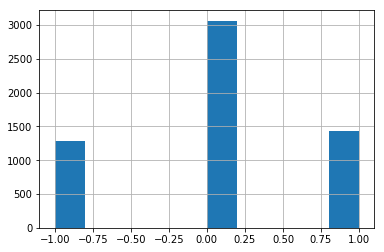

In [36]:
gold['target'].hist()

In [37]:
gold_gains.gains.describe()

count     5780.000000
mean         2.190917
std        903.824695
min     -11390.500000
25%       -237.500000
50%          9.500000
75%        294.500000
max       6555.000000
Name: gains, dtype: float64

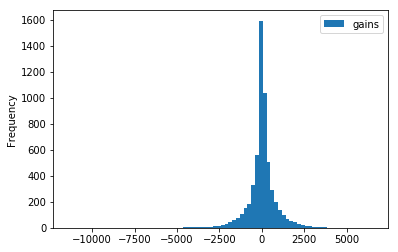

In [38]:
gold_gains[['gains']].plot.hist(bins=80)

In [39]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
treshold = 150
corn_gains = create_trade_outcomes(corn, contracts, treshold)
corn_gains.head(5)

              gains     Open     High      Low   Settle  target
Date                                                           
1996-01-02  106.875  18550.0  18762.5  18512.5  18662.5       0
1996-01-03   47.500  18650.0  18725.0  18512.5  18700.0       0
1996-01-04 -213.750  18675.0  18687.5  18250.0  18450.0      -1
1996-01-05  -11.875  18337.5  18450.0  18275.0  18325.0       0
1996-01-08 -190.000  18225.0  18225.0  18000.0  18025.0      -1


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,-1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,-1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,1.0


In [40]:
corn_gains.gains.describe()

count    5789.000000
mean        2.203101
std       310.165899
min     -1983.125000
25%      -118.750000
50%         0.000000
75%       130.625000
max      1888.125000
Name: gains, dtype: float64

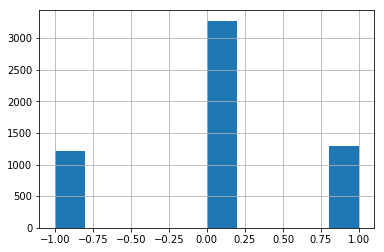

In [41]:
get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.target.hist()

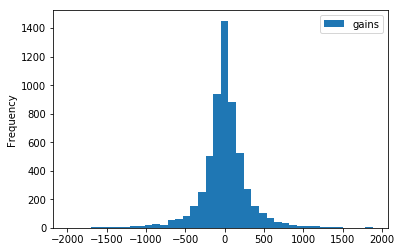

In [42]:
corn_gains[['gains']].plot.hist(bins=40)

In [43]:
corn_gains.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,-1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,-1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,1.0
1996-01-09,-249.375,18375.0,18375.0,18100.0,18112.5,-1.0
1996-01-10,-225.625,18112.5,18112.5,17800.0,17875.0,-1.0
1996-01-11,237.500,17887.5,18150.0,17887.5,18137.5,1.0
1996-01-12,142.500,18100.0,18262.5,18075.0,18250.0,0.0


In [44]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
treshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, treshold)
coffee_gains.head(5)

                gains     Open      High      Low    Settle  target
Date                                                               
1996-01-02  -480.9375  34725.0  35550.00  34162.5  34218.75      -1
1996-01-03  1015.3125  34087.5  35400.00  33900.0  35156.25       1
1996-01-04  1727.8125  34875.0  36787.50  34875.0  36693.75       1
1996-01-05  -445.3125  36562.5  37293.75  35925.0  36093.75      -1
1996-01-10   890.6250  35775.0  36843.75  35550.0  36712.50       1


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,1015.3125,34087.5,35400.00,33900.00,35156.25,1.0
1996-01-03,1727.8125,34875.0,36787.50,34875.00,36693.75,1.0
1996-01-04,-445.3125,36562.5,37293.75,35925.00,36093.75,-1.0
1996-01-05,890.6250,35775.0,36843.75,35550.00,36712.50,1.0
1996-01-10,1977.1875,36562.5,38812.50,36468.75,38643.75,1.0


In [45]:
coffee_gains.gains.describe()

count     5751.000000
mean        -2.638889
std        968.552015
min     -12842.812500
25%       -213.750000
50%          0.000000
75%        231.562500
max       6929.062500
Name: gains, dtype: float64

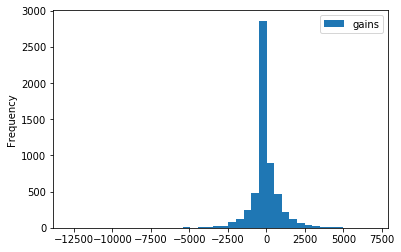

In [46]:
coffee_gains[['gains']].plot.hist(bins=40)

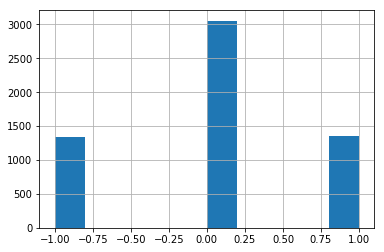

In [47]:
get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.target.hist()

In [48]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,92.60,94.80,91.10,91.25,5719.0,18717.0,95.945946,1.0
1996-01-03,90.90,94.40,90.40,93.75,6461.0,19257.0,23.863636,1.0
1996-01-04,93.00,98.10,93.00,97.85,8865.0,18918.0,3.246753,-1.0
1996-01-05,97.50,99.45,95.80,96.25,6833.0,18599.0,35.359116,1.0
1996-01-10,95.40,98.25,94.80,97.90,5146.0,18542.0,17.127072,1.0
1996-01-12,103.00,103.85,100.80,102.70,5984.0,17314.0,8.550186,-1.0
1996-01-15,102.70,103.00,98.70,98.95,6128.0,17227.0,36.431227,1.0
1996-01-16,97.75,105.25,97.75,103.90,9918.0,17601.0,9.090909,1.0
1996-01-17,103.05,105.50,103.05,104.30,6504.0,16852.0,7.947020,1.0


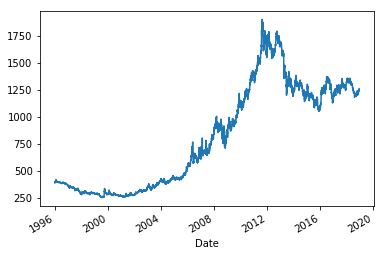

In [49]:
gold['Open'].plot()

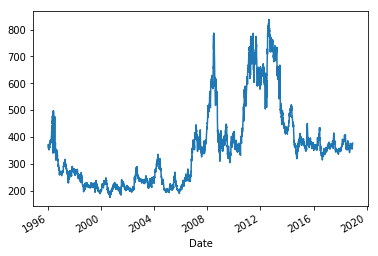

In [50]:
corn['Open'].plot()

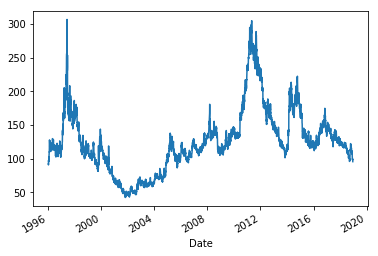

In [51]:
coffee['Open'].plot()

In [52]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        # print(type(idx), type(idx.astype(datetime.datetime)))
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [53]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [54]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2018-11-23,1213.5,1220.9,1205.6,1211.2,202123.0,199751.0,1212.6,1214.7,1181.2,1189.3,...,0.942235,0.087364,0.916625,0.162104,4,17,11,3,36.363636,0.0
2018-11-26,1212.6,1214.7,1181.2,1189.3,353644.0,164500.0,1189.4,1192.7,1170.3,1178.4,...,0.942235,0.087364,0.916625,0.162104,0,18,11,3,38.277512,-1.0
2018-11-27,1189.4,1192.7,1170.3,1178.4,288389.0,106069.0,1184.4,1197.2,1182.4,1190.8,...,0.942235,0.087364,0.916625,0.162104,1,19,11,3,59.808612,1.0
2018-11-28,1184.4,1197.2,1182.4,1190.8,177818.0,77556.0,1196.6,1197.7,1182.6,1190.8,...,0.916625,0.162104,0.957183,0.139100,2,20,11,3,21.282799,0.0
2018-11-29,1196.6,1197.7,1182.6,1190.8,196186.0,259190.0,1190.7,1196.8,1171.3,1173.9,...,0.916625,0.162104,0.957183,0.139100,3,21,11,3,19.825073,-1.0
2018-11-30,1190.7,1196.8,1171.3,1173.9,236195.0,271613.0,1175.1,1178.4,1162.2,1169.4,...,0.916625,0.162104,0.957183,0.139100,4,22,11,3,31.195335,1.0
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,273896.0,1174.3,1180.3,1168.4,1177.8,...,0.916625,0.162104,0.957183,0.139100,0,1,12,3,0.533333,1.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,273718.0,1182.6,1190.2,1158.6,1176.5,...,0.916625,0.162104,0.957183,0.139100,1,2,12,3,0.692841,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,275782.0,1172.8,1177.1,1168.1,1170.1,...,0.957183,0.139100,0.859876,0.275776,2,3,12,3,12.536443,0.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,271766.0,1171.4,1182.3,1167.2,1177.5,...,0.957183,0.139100,0.859876,0.275776,3,4,12,3,18.584071,1.0


In [55]:
gold_data.shape

(5276, 3046)

In [56]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [57]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

In [58]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 3045
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)

    # pca_lst = []
    # pca = PCA(n_components=50, random_state=2234)
    pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(3040))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2233)
    # pca.fit(df_train[list(range(2016, 2016 + 504))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2232)
    # pca.fit(df_train[list(range(2016 + 504, 2016 + 1008))])
    # pca_lst.append(pca)

    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 3045
    # df_pca_lst = []
    df_pca = pca.transform(df[list(range(3040))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[1].transform(df[list(range(2016, 2016 + 504))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[2].transform(df[list(range(2016 + 504, 2016 + 1008))])
    # df_pca_lst.append(df_pca)
    
    df_pca = np.concatenate((df_pca, df[list(range(3040,label_index))].values), axis=1)
    return df_pca

In [59]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [60]:
# plt.plot(np.cumsum(gold_pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [61]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [62]:
def plot_pca_relation(pca_data, label_train, x):
    labels = [0, 1, -1]
    labl={-1: 'Short', 0:'No Trade', 1:'Long'}
    plt.figure(1)

    for i in range(x):
        for j in range(i+1, x):
            fig, ax = plt.subplots(figsize=(7,5))
            fig.patch.set_facecolor('white')
            Xax = pca_data[:, i]
            Yax = pca_data[:, j]
            for l in labels:
                ix = np.where(label_train==l)
                ax.scatter(Xax[ix], Yax[ix], label=labl[l])

            plt.xlabel("Principal Component No " + str(i), fontsize=14)
            plt.ylabel("Second Principal Component No " + str(j), fontsize=14)
            plt.legend()
            plt.show()

In [63]:
pca_components = 3

In [64]:
# plot_pca_relation(gold_pca[0].transform(gold_train[list(range(2016))]), gold_label_train, pca_components)

In [65]:
# plot_pca_relation(corn_pca[0].transform(corn_train[list(range(2016))]), corn_label_train, pca_components)

In [66]:
# plot_pca_relation(coffee_pca[0].transform(coffee_train[list(range(2016))]), coffee_label_train, pca_components)

In [67]:
# gold_label_test.head(20)

In [68]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import lightgbm as lgb
import xgboost as xgb


X = pca_transform(gold_train, gold_pca)
train_data = lgb.Dataset(X, label=list(map(lambda x: x, gold_label_train)), categorical_feature='auto') # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: x, gold_label_test)), categorical_feature='auto')
param = {}
param = {'num_leaves':31, 'objective':'binary'}
param['objective'] = 'binary'
# param['metric'] = 'logloss'
# param['boosting_type'] = 'gbdt'
# param['metric'] = 'rmse'
param['boosting'] = 'dart'
param['max_bin'] = 50
# param['metric'] = 'multi_error'
param['metric'] = 'binary_error'
param['learning_rate'] = 0.05
param['num_class'] = 1
param['max_bin'] = 50
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 2000
# param = {'boosting_type': 'gbdt',
#          'max_depth' : -1,
#           'objective': 'binary',
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 64,
#           'learning_rate': 0.05,
#           'max_bin': 512,
#           'subsample_for_bin': 200,
#           'subsample': 1,
#           'subsample_freq': 1,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 5,
#           'reg_lambda': 10,
#           'min_split_gain': 0.5,
#           'min_child_weight': 1,
#           'min_child_samples': 5,
#           'scale_pos_weight': 1,
#           'num_class' : 1,
#           'metric' : 'binary_error'}
gold_xgb_use = False
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

# gold_clf = RandomForestClassifier(n_estimators=150, random_state=1100)
# gold_clf = AdaBoostClassifier(n_estimators=100, random_state=1100, learning_rate=0.1)
# gold_clf = MLPClassifier(hidden_layer_sizes=(100, 3), solver='sgd', random_state=1100)
# gold_clf = MLPRegressor(hidden_layer_sizes=(100, 3), solver='sgd', max_iter=2000, alpha=0.1, random_state=1100)
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, gold_label_train))
# gold_clf.fit(X, gold_label_train)
# gold_clf.fit(X, gold_label_train, sample_weight=sample_weight)

[1]	valid_0's binary_error: 0.351885
[2]	valid_0's binary_error: 0.351885
[3]	valid_0's binary_error: 0.351885
[4]	valid_0's binary_error: 0.351885
[5]	valid_0's binary_error: 0.351885
[6]	valid_0's binary_error: 0.351885
[7]	valid_0's binary_error: 0.351885
[8]	valid_0's binary_error: 0.351885
[9]	valid_0's binary_error: 0.351885
[10]	valid_0's binary_error: 0.351885
[11]	valid_0's binary_error: 0.351885
[12]	valid_0's binary_error: 0.351885
[13]	valid_0's binary_error: 0.351885
[14]	valid_0's binary_error: 0.351885
[15]	valid_0's binary_error: 0.351885
[16]	valid_0's binary_error: 0.351885
[17]	valid_0's binary_error: 0.351885
[18]	valid_0's binary_error: 0.351885
[19]	valid_0's binary_error: 0.351885
[20]	valid_0's binary_error: 0.351885
[21]	valid_0's binary_error: 0.351885
[22]	valid_0's binary_error: 0.351885
[23]	valid_0's binary_error: 0.351885
[24]	valid_0's binary_error: 0.351885
[25]	valid_0's binary_error: 0.351885
[26]	valid_0's binary_error: 0.351885
[27]	valid_0's binary

[290]	valid_0's binary_error: 0.351885
[291]	valid_0's binary_error: 0.351885
[292]	valid_0's binary_error: 0.351885
[293]	valid_0's binary_error: 0.351885
[294]	valid_0's binary_error: 0.351885
[295]	valid_0's binary_error: 0.351885
[296]	valid_0's binary_error: 0.351885
[297]	valid_0's binary_error: 0.351885
[298]	valid_0's binary_error: 0.351885
[299]	valid_0's binary_error: 0.351885
[300]	valid_0's binary_error: 0.351885
[301]	valid_0's binary_error: 0.351885
[302]	valid_0's binary_error: 0.351885
[303]	valid_0's binary_error: 0.351885
[304]	valid_0's binary_error: 0.351885
[305]	valid_0's binary_error: 0.351885
[306]	valid_0's binary_error: 0.351885
[307]	valid_0's binary_error: 0.351885
[308]	valid_0's binary_error: 0.351885
[309]	valid_0's binary_error: 0.351885
[310]	valid_0's binary_error: 0.351885
[311]	valid_0's binary_error: 0.351885
[312]	valid_0's binary_error: 0.351885
[313]	valid_0's binary_error: 0.351885
[314]	valid_0's binary_error: 0.351885
[315]	valid_0's binary_er

[605]	valid_0's binary_error: 0.351885
[606]	valid_0's binary_error: 0.351885
[607]	valid_0's binary_error: 0.351885
[608]	valid_0's binary_error: 0.351885
[609]	valid_0's binary_error: 0.351885
[610]	valid_0's binary_error: 0.351885
[611]	valid_0's binary_error: 0.351885
[612]	valid_0's binary_error: 0.351885
[613]	valid_0's binary_error: 0.351885
[614]	valid_0's binary_error: 0.351885
[615]	valid_0's binary_error: 0.351885
[616]	valid_0's binary_error: 0.351885
[617]	valid_0's binary_error: 0.351885
[618]	valid_0's binary_error: 0.351885
[619]	valid_0's binary_error: 0.351885
[620]	valid_0's binary_error: 0.351885
[621]	valid_0's binary_error: 0.351885
[622]	valid_0's binary_error: 0.351885
[623]	valid_0's binary_error: 0.351885
[624]	valid_0's binary_error: 0.351885
[625]	valid_0's binary_error: 0.351885
[626]	valid_0's binary_error: 0.351885
[627]	valid_0's binary_error: 0.351885
[628]	valid_0's binary_error: 0.351885
[629]	valid_0's binary_error: 0.351885
[630]	valid_0's binary_er

[966]	valid_0's binary_error: 0.351885
[967]	valid_0's binary_error: 0.351885
[968]	valid_0's binary_error: 0.351885
[969]	valid_0's binary_error: 0.351885
[970]	valid_0's binary_error: 0.351885
[971]	valid_0's binary_error: 0.351885
[972]	valid_0's binary_error: 0.351885
[973]	valid_0's binary_error: 0.351885
[974]	valid_0's binary_error: 0.351885
[975]	valid_0's binary_error: 0.351885
[976]	valid_0's binary_error: 0.351885
[977]	valid_0's binary_error: 0.351885
[978]	valid_0's binary_error: 0.351885
[979]	valid_0's binary_error: 0.351885
[980]	valid_0's binary_error: 0.351885
[981]	valid_0's binary_error: 0.351885
[982]	valid_0's binary_error: 0.351885
[983]	valid_0's binary_error: 0.351885
[984]	valid_0's binary_error: 0.351885
[985]	valid_0's binary_error: 0.351885
[986]	valid_0's binary_error: 0.351885
[987]	valid_0's binary_error: 0.351885
[988]	valid_0's binary_error: 0.351885
[989]	valid_0's binary_error: 0.351885
[990]	valid_0's binary_error: 0.351885
[991]	valid_0's binary_er

[1328]	valid_0's binary_error: 0.351885
[1329]	valid_0's binary_error: 0.351885
[1330]	valid_0's binary_error: 0.351885
[1331]	valid_0's binary_error: 0.351885
[1332]	valid_0's binary_error: 0.351885
[1333]	valid_0's binary_error: 0.351885
[1334]	valid_0's binary_error: 0.351885
[1335]	valid_0's binary_error: 0.351885
[1336]	valid_0's binary_error: 0.351885
[1337]	valid_0's binary_error: 0.351885
[1338]	valid_0's binary_error: 0.351885
[1339]	valid_0's binary_error: 0.351885
[1340]	valid_0's binary_error: 0.351885
[1341]	valid_0's binary_error: 0.351885
[1342]	valid_0's binary_error: 0.351885
[1343]	valid_0's binary_error: 0.351885
[1344]	valid_0's binary_error: 0.351885
[1345]	valid_0's binary_error: 0.351885
[1346]	valid_0's binary_error: 0.351885
[1347]	valid_0's binary_error: 0.351885
[1348]	valid_0's binary_error: 0.351885
[1349]	valid_0's binary_error: 0.351885
[1350]	valid_0's binary_error: 0.351885
[1351]	valid_0's binary_error: 0.351885
[1352]	valid_0's binary_error: 0.351885


[1671]	valid_0's binary_error: 0.351885
[1672]	valid_0's binary_error: 0.351885
[1673]	valid_0's binary_error: 0.351885
[1674]	valid_0's binary_error: 0.351885
[1675]	valid_0's binary_error: 0.351885
[1676]	valid_0's binary_error: 0.351885
[1677]	valid_0's binary_error: 0.351885
[1678]	valid_0's binary_error: 0.351885
[1679]	valid_0's binary_error: 0.351885
[1680]	valid_0's binary_error: 0.351885
[1681]	valid_0's binary_error: 0.351885
[1682]	valid_0's binary_error: 0.351885
[1683]	valid_0's binary_error: 0.351885
[1684]	valid_0's binary_error: 0.351885
[1685]	valid_0's binary_error: 0.351885
[1686]	valid_0's binary_error: 0.351885
[1687]	valid_0's binary_error: 0.351885
[1688]	valid_0's binary_error: 0.351885
[1689]	valid_0's binary_error: 0.351885
[1690]	valid_0's binary_error: 0.351885
[1691]	valid_0's binary_error: 0.351885
[1692]	valid_0's binary_error: 0.351885
[1693]	valid_0's binary_error: 0.351885
[1694]	valid_0's binary_error: 0.351885
[1695]	valid_0's binary_error: 0.351885


[1961]	valid_0's binary_error: 0.351885
[1962]	valid_0's binary_error: 0.351885
[1963]	valid_0's binary_error: 0.351885
[1964]	valid_0's binary_error: 0.351885
[1965]	valid_0's binary_error: 0.351885
[1966]	valid_0's binary_error: 0.351885
[1967]	valid_0's binary_error: 0.351885
[1968]	valid_0's binary_error: 0.351885
[1969]	valid_0's binary_error: 0.351885
[1970]	valid_0's binary_error: 0.351885
[1971]	valid_0's binary_error: 0.351885
[1972]	valid_0's binary_error: 0.351885
[1973]	valid_0's binary_error: 0.351885
[1974]	valid_0's binary_error: 0.351885
[1975]	valid_0's binary_error: 0.351885
[1976]	valid_0's binary_error: 0.351885
[1977]	valid_0's binary_error: 0.351885
[1978]	valid_0's binary_error: 0.351885
[1979]	valid_0's binary_error: 0.351885
[1980]	valid_0's binary_error: 0.351885
[1981]	valid_0's binary_error: 0.351885
[1982]	valid_0's binary_error: 0.351885
[1983]	valid_0's binary_error: 0.351885
[1984]	valid_0's binary_error: 0.351885
[1985]	valid_0's binary_error: 0.351885


In [69]:
%%capture cpt_corn_train
X = pca_transform(corn_train, corn_pca)

y = list(map(lambda x: x, corn_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature='auto')
X_test = pca_transform(corn_test, corn_pca)
y_test = list(map(lambda x: x, corn_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')
corn_xgb_use = False
corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [70]:
%%capture cpt_coffee_train
X = pca_transform(coffee_train, coffee_pca)

train_data = lgb.Dataset(X, label=list(map(lambda x: x, coffee_label_train)), categorical_feature='auto')
X_test = pca_transform(coffee_test, coffee_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: x, coffee_label_test)), categorical_feature='auto')
coffee_xgb_use = False
coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [71]:
# X_test = pca_transform(corn_test, corn_pca)
# corn_clf.score(X_test, corn_label_test)

In [72]:
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, xgb_use=False, stop_loss=500):
    global account_size, fee
    acc = account_size
    df = pca_transform(df, pca)
    if not xgb_use:
        preds = model.predict(df)
        predictions = []
        for p in preds:
            if p > 0.45:
                predictions.append(-1)
            else:
                predictions.append(0)
            # predictions.append(0)
    else:
        preds = list(map(lambda x: x, model.predict(df)))
        predictions = []
        for s, n, l in preds:
            if s > 0.55:
                predictions.append(-1)
            elif l > 0.55:
                predictions.append(1)
            predictions.append(0)
    print(np.unique(predictions))
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(p,l)
        # print(p)
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1:
            # print("Short ", p, l)
            short = 1
            if (v[2] - v[1]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1:
            long = 1
            if (v[1] - v[3]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(p)
        dct['label'].append(l)
        dct['gains'].append(gains)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

[-1]


(0, 18000)

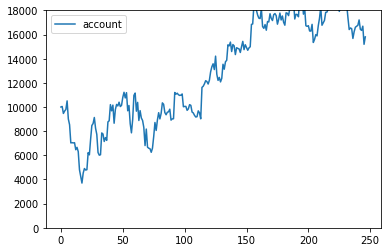

In [73]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, xgb_use=gold_xgb_use, stop_loss=1500)
ax1 = gold_account[['account']].plot()
ax1.set_ylim(0,18000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f055a9dc278>,
      dtype=object)

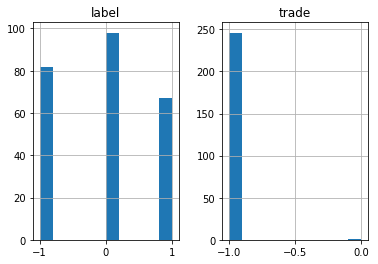

In [74]:
gold_account[['trade', 'label']].hist()

In [75]:
gold_account[gold_account['short'] == 1].gains.sum()

5805.99999999996

In [76]:
gold_account[gold_account['long'] == 1].gains.sum()

0.0

[-1]


(0, 12000)

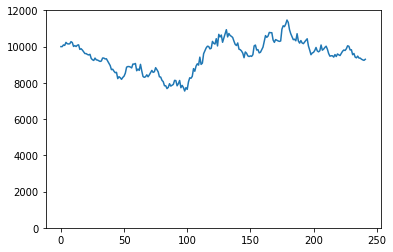

In [77]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, xgb_use=corn_xgb_use, stop_loss=400)
ax1 = corn_account.account.plot()
ax1.set_ylim(0,12000)

In [78]:
corn_account[corn_account['short'] == 1].gains.sum()

-700.875

In [79]:
corn_account[corn_account['long'] == 1].gains.sum()

0.0

[-1  0]


(0, 14000)

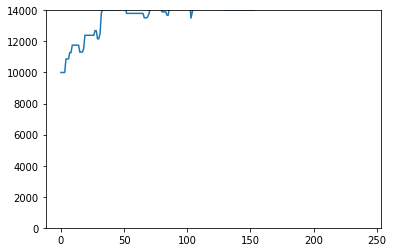

In [80]:
coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, xgb_use=coffee_xgb_use, stop_loss=1000)
ax1 = coffee_account.account.plot()
ax1.set_ylim(0,14000)

In [179]:
coffee_account[coffee_account['short'] == 1].gains.sum()

3618.0000000000005

In [176]:
coffee_account[coffee_account['long'] == 1].gains.sum()

0.0